In [ ]:
%matplotlib inline

Processing steps to create trial-unique beta maps from the CIMAQ fMRI data 
(memory task: image encoding), within a single subject:

Outputs (beta maps) are meant to be fed as features to a within-subject nilearn classifier.

Input:
    - task (event) files 
    - confound (motion, etc) files generated load_confound
    - preprocessed FMRIPrep data (4D .nii file)
        - note: data are not smoothed nor denoised)
Output: 1 map (3D .nii file) of beta (regression) weights for each trial, and 1 
concatenated 4D file of these 3D maps (trials ordered chronologically).

Note: comparing 2 different ways to model trials of no interest

version 1: Separate model for each trial
    - Trial of interest modelled as a separate condition (1 regressor)
    - All other trials modelled in either the Encoding or Control condition (2 regressors)
**Update: betas from version 1 lead to much better enc/ctl trial classification**

version 2: a separate model is built for each trial, with the trial of interest modelled as a separate condition (1 regressor), and all the other trials modelled as a single "other" condition (1 regressor)
**Update: betas from version2 lead to poorer enc/ctl trial classification**

Reference: how to derive beta maps for MVPA classification (Mumford et al., 2012):
https://www.sciencedirect.com/science/article/pii/S1053811911010081

Also creating contrasts per condition (to derive features for between-subject classification): 
 - Modeling enconding and control conditions across trials
     - 3 beta maps:
         - encoding (enc) , control (ctl), and encoding minus control (enc_minus_ctl)
 - Modeling control condition, as well as the encoding condition according to task performance:
    - miss and hit (post-scan image recognition performance)
    - 5 beta maps:
        - miss, hit hit_minus_miss, hit_minus_ctl, miss_minus_ctl
    - Modeling control condition & encoding condition according to task performance:
        - miss, wrong source, and correct source
    - 7 beta maps:
         - wrong_source, corr_source, cs_minus_ws, cs_minus_miss, ws_minus_miss, cs_minus_ctl, ws_minus_ctl


In [30]:
import glob
import more_itertools
import nibabel
import nilearn
import numpy as np
import os
import pandas as pd
import re
import scipy
import sys


from load_confounds import Minimal
from numpy import nan as NaN
from matplotlib import pyplot as plt
from nilearn.glm.first_level import FirstLevelModel, check_design_matrix, check_events
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn import plotting as niplot
from nilearn import image as nimage
from nilearn.masking import apply_mask
from nilearn.signal import clean
from tqdm import tqdm

#libraries need to be installed in conda environment with pip install

In [29]:
# nilearn.glm.first_level.run_glm


Help on module nilearn.glm.first_level.first_level in nilearn.glm.first_level:

NAME
    nilearn.glm.first_level.first_level

DESCRIPTION
    This module presents an interface to use the glm implemented in
    nistats.regression.
    
    It contains the GLM and contrast classes that are meant to be the main objects
    of fMRI data analyses.
    
    Author: Bertrand Thirion, Martin Perez-Guevara, 2016

CLASSES
    nilearn.glm._base.BaseGLM(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin, nilearn._utils.cache_mixin.CacheMixin)
        FirstLevelModel
    
    class FirstLevelModel(nilearn.glm._base.BaseGLM)
     |  FirstLevelModel(t_r=None, slice_time_ref=0.0, hrf_model='glover', drift_model='cosine', high_pass=0.01, drift_order=1, fir_delays=[0], min_onset=-24, mask_img=None, target_affine=None, target_shape=None, smoothing_fwhm=None, memory=Memory(location=None), memory_level=1, standardize=False, signal_scaling=0, noise_model='ar1', verbose=0, n_jobs=1, minimize_memory=Tr

Step 1: Load confound parameters outputed from the NIAK preprocessing pipeline (slow signal drift, motion parameters, mean white matter and mean ventricle signal intensity)

**Note: The full NIAK preprocessing pipeline scrubs (regresses out) motion outlier frames, which may not be compatible with other software like Nilearn or Nistats.
Intermediate data from the preprocessing pipeline should be used that have been slice-timed, co-registered and resampled (motion-corrected).  

These data are found under the **resample** directory (not under fMRI), in .nii format, with accompanying _extra.mat and confounds.tsv.gz files. 
These data have undergone **no smoothing**, and confounds have NOT been regressed out. 

Use gunzip *gz command to unzip .tsv files inside working directory

**Update: the nistats first-level model can model some of the slow drift and noise parameters (not used here). Here, I use all the confounds in *counfounds.tsv (including slow drift) as regressors, so I don't model slow drift, etc in the first-level model (it's redundant). 


In [54]:
sorted(os.listdir())

['.DS_Store',
 '.ipynb_checkpoints',
 'CIMAQ_getBetaMaps.ipynb',
 'CIMAQ_getNetworkFeatures_OLD_doesNotWork.ipynb',
 'Create_group_mask.ipynb',
 'cimaq_getNetworkWeights.py',
 'cimaq_getbetas.py',
 'create_bmap.py',
 'difumo_atlases',
 'getbetas1_cmd.sh',
 'getbetas2_cmd.sh',
 'getbetas3_cmd.sh',
 'getbetas4_cmd.sh',
 'getbetas_cmd.sh',
 'getnetworkweights1_cmd.sh',
 'getnetworkweights2_cmd.sh',
 'getnetworkweights3_cmd.sh',
 'getnetworkweights4_cmd.sh',
 'getnetworkweights_cmd.sh',
 'icbm152_2009',
 'msdl_atlas',
 'nilearn_cache',
 'smith_2009']

In [36]:
fmriprep_dir = '/data/simexp/cimaq_preproc/fmriprep/'
evdir = '/data/simexp/CIMAQ_AS_BIDS/'

In [52]:
import os
from cimaq_utils import absoluteFilePaths

inc_str = lambda inc, l: [i for i in l if any(s in i for s in inc)]
eveseq = lambda it: tuple(i[1] for i in enumerate(it) if i[0] % 2 == 0)
oddseq = lambda it: tuple(i[1] for i in enumerate(it) if i[0] % 2 != 0)

space, task, mdlt = 'MNI152NLin2009cAsym', 'memory', 'T1w'
anat_suffix = f'_space-{space}_desc-preproc_{mdlt}.nii.gz'
bold_suffix = f'_task-{task}_space-{space}_desc-preproc_bold.nii.gz'
mask_suffix = f'_task-{task}_space-{space}_desc-brain_mask.nii.gz'

# def absoluteFilePaths(src) -> list:
#     """
#     Return all absolute file paths in ``src`` recursively.
#     """

#     for dpath,_,fnames in os.walk(src):
#         for f in fnames: yield os.path.abspath(os.path.join(dpath, f))

bolds, masks, t1w = [inc_str([suffix], list(absoluteFilePaths(fmriprep_dir)))
                     for suffix in [bold_suffix, mask_suffix, anat_suffix]]        

taskfiles = tuple(absoluteFilePaths(evdir))[1:]
events, behav = eveseq(taskfiles), oddseq(taskfiles)
tst=pd.DataFrame(more_itertools.flatten([bolds, masks, events, behav]))
tst['sub_id'] = [next(re.findall('sub-\d{7}', item).__iter__())
                 for item in tst[0].values.tolist()]
tst['ses_id'] = [next(re.findall('ses-V\d{2}', item).__iter__())
                 for item in tst[0].values.tolist()]
incomplete = [tst.iloc[i] for i in
              list(tst.groupby(['sub_id', 'ses_id']).groups.values())
              if len(tst.iloc[i]) < 4]
complete = [tst.iloc[i] for i in
            list(tst.groupby(['sub_id', 'ses_id']).groups.values())
            if len(tst.iloc[i]) == 4]
cimaq_files = pd.DataFrame((sorted(more_itertools.flatten([comp[0].values.tolist()+[item]
                                                           for item in t1w if
                                                           comp.sub_id.unique()[0] in item]))
                            for comp in complete),
                           columns=['behavs','events','t1w_anats','masks','bolds'])
cimaq_files.shape

ModuleNotFoundError: No module named 'cimaq_utils'

In [51]:
os.listdir(os.path.dirname(cimaq_files.bolds[0]))

['sub-3002498_ses-V10_task-memory_space-fsnative_hemi-R_bold.json',
 'sub-3002498_ses-V10_task-rest_from-T1w_to-scanner_mode-image_xfm.txt',
 'sub-3002498_ses-V10_task-memory_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz',
 'sub-3002498_ses-V10_task-rest_desc-confounds_timeseries.tsv',
 'sub-3002498_ses-V10_task-rest_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
 'sub-3002498_ses-V10_task-memory_from-T1w_to-scanner_mode-image_xfm.txt',
 'sub-3002498_ses-V10_task-rest_space-T1w_desc-preproc_bold.nii.gz',
 'sub-3002498_ses-V10_task-rest_space-MNI152NLin6Asym_desc-brain_mask.json',
 'sub-3002498_ses-V10_task-memory_space-T1w_boldref.nii.gz',
 'sub-3002498_ses-V10_task-memory_space-MNI152NLin6Asym_boldref.nii.gz',
 'sub-3002498_ses-V10_task-memory_space-T1w_desc-brain_mask.nii.gz',
 'sub-3002498_ses-V10_task-rest_space-MNI152NLin6Asym_desc-preproc_bold.json',
 'sub-3002498_ses-V10_task-rest_space-MNI152NLin6Asym_boldref.nii.gz',
 'sub-3002498_ses-V10_task-rest_desc-confounds_timeseri

Step 2: create events variable, and events.tsv file from the 'sub-*_ses-4_task-memory_events.tsv' task file outputed by the cimaq_convert_eprime_to_bids_event.py script 

Number of rows = number of trials (the first-level model will use onset times to match conditions (trials) with fMRI frames).

Documentation:
https://nistats.github.io/auto_examples/04_low_level_functions/write_events_file.html#sphx-glr-auto-examples-04-low-level-functions-write-events-file-py

Each encoding trial is modelled as a different condition (under trial_type column) so that it is modelled separately when creating the design matrix. The trial has its own column in the design matrix; the other columns = other trials (modelled together as single regressor), and confound regressors.

**Note: Some scans were cut short, meaning that the last few trials do not have associated brain activation frames, and they need to be left out of the analysis; 310 frames = full scan, 288 frames = incomplete (~15 participants).
"unscanned" trials need to be excluded from the model (about ~2-4 trials missing).
288*2.5 = 720s. 
Trial #115 (out of 117) offset time ~ 710s
Trial #116 (out of 117) onset ~ 723s

### Create unique trial identifiers & clean fMRI BOLD signal

In [38]:
bold00 = nimage.load_img(cimaq_files.bolds[0])
mask00 = nimage.load_img(cimaq_files.masks[0])
anat00 = nimage.load_img(cimaq_files.t1w_anats[0])
conf00 = Minimal().load(cimaq_files.bolds[0])
events00 = pd.read_csv(cimaq_files.events[0], sep='\t')
clean_params = dict(confounds=conf00,#bold00.header.get_zooms()[0]*3),
                    detrend=False, standardize=False,
                    standardize_confounds=False,
                    high_pass=None, low_pass=None,
                    t_r=bold00.header.get_zooms()[-1],
                    ensure_finite=True)
cleaned_bold = nilearn.masking.unmask(clean(apply_mask(bold00, mask00,smoothing_fwhm=8,
                                                       dtype='f'),
                                                       **clean_params),
                                            mask00)
ctl_count = (val+str(ind).zfill(2) for ind, val in
                 enumerate((val for val in events00.trial_type.values
                            if val == 'Ctl'), 1))
enc_count = (val+str(ind).zfill(2) for ind, val in
                 enumerate((val for val in events00.trial_type.values
                            if val == 'Enc'), 1))
events00 = events00.rename({'trial_type':'condition'},axis=1)
events00.insert(loc=1, column='trial_type',
                value=[next(ctl_count) if 'Ctl' in row[1].condition else next(enc_count)
                       for row in events00.iterrows()])
events00

trial_number trial_type condition stim_id  position_correct  \
0               4      Ctl01       Ctl     NaN                 8   
1               5      Enc01       Enc   Old56                 6   
2               6      Enc02       Enc   Old10                 5   
3               7      Enc03       Enc   Old24                 6   
4               8      Enc04       Enc   Old77                 9   
..            ...        ...       ...     ...               ...   
112           116      Enc75       Enc   Old48                 6   
113           117      Ctl39       Ctl     NaN                 9   
114           118      Enc76       Enc   Old18                 5   
115           119      Enc77       Enc   Old30                 5   
116           120      Enc78       Enc   Old26                 8   

     response_time  onset  offset   isi  duration                   stim_file  \
0              1.8   11.5    14.6   5.5       3.0                         NaN   
1              1.6   20.1    23.1   0.5       3.0  sporting_boxing_gloves.bmp   
2              1.3   23.6    26.6   1.0       3.0          animal_penguin.bmp   
3              1.2   27.6    30.6   1.0       3.0         food_softcheese.bmp   
4              1.0   31.6    34.6   1.5       3.0            vegie_radish.bmp   
..             ...    ...     ...   ...       ...                         ...   
112            0.7  694.4   697.4   6.0       3.0       musical_piano_old.bmp   
113            0.7  703.4   706.5  10.0       3.0                         NaN   
114            1.0  717.0   720.0   5.0       3.0          food_cracker02.bmp   
115            2.0  725.0   728.0   1.0       3.0   kitchen_cookie cutter.bmp   
116            1.0  729.0   732.0  18.0       3.0              food_toast.bmp   

    stim_category  recognition_response  recognition_responsetime  \
0             NaN                   NaN                       NaN   
1        sporting                   1.0                       7.0   
2          animal                   1.0                       2.3   
3            food                   1.0                       4.1   
4           vegie                   2.0                       NaN   
..            ...                   ...                       ...   
112       musical                   1.0                       2.2   
113           NaN                   NaN                       NaN   
114          food                   1.0                       2.0   
115       kitchen                   1.0                       2.0   
116          food                   1.0                       1.8   

     position_response  position_responsetime  recognition_accuracy  \
0                  NaN                    NaN                   NaN   
1                  4.0                    2.4                   1.0   
2                  3.0                    1.7                   1.0   
3                  4.0                    0.8                   1.0   
4                  NaN                    NaN                   0.0   
..                 ...                    ...                   ...   
112                4.0                    0.9                   1.0   
113                NaN                    NaN                   NaN   
114                3.0                    1.7                   1.0   
115                3.0                    1.7                   1.0   
116                1.0                    0.7                   1.0   

     position_accuracy recognition_performance  
0                  NaN                     NaN  
1                  0.0                    Miss  
2                  0.0                    Miss  
3                  0.0                    Miss  
4                  NaN                      FA  
..                 ...                     ...  
112                0.0                    Miss  
113                NaN                     NaN  
114                0.0                    Miss  
115                0.0                    M

In [45]:
design_params = dict(frame_times=np.arange(cleaned_bold.shape[-1]) *
                                 cleaned_bold.header.get_zooms()[-1],
                     events=events00[['onset','trial_type','duration', 'condition']],
                     drift_model=None,
#                      add_regs=Minimal().load(subject_data.bolds),
                     hrf_model='spm')

glm_params = dict(drift_model=design_params['drift_model'],
                  standardize=False,
                  noise_model='ar1',
                  hrf_model=design_params['hrf_model'])
design00 = make_first_level_design_matrix(**design_params)
# design_matrix00 = model00.design_matrices_[0]

# plot_design_matrix(design_matrix)


/home/fnadeau/myenv/lib/python3.7/site-packages/nilearn/glm/first_level/experimental_paradigm.py:90: UserWarning: Unexpected column `condition` in events data will be ignored.
  "data will be ignored.").format(unexpected_column))
/home/fnadeau/myenv/lib/python3.7/site-packages/nilearn/_utils/glm.py:309: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')



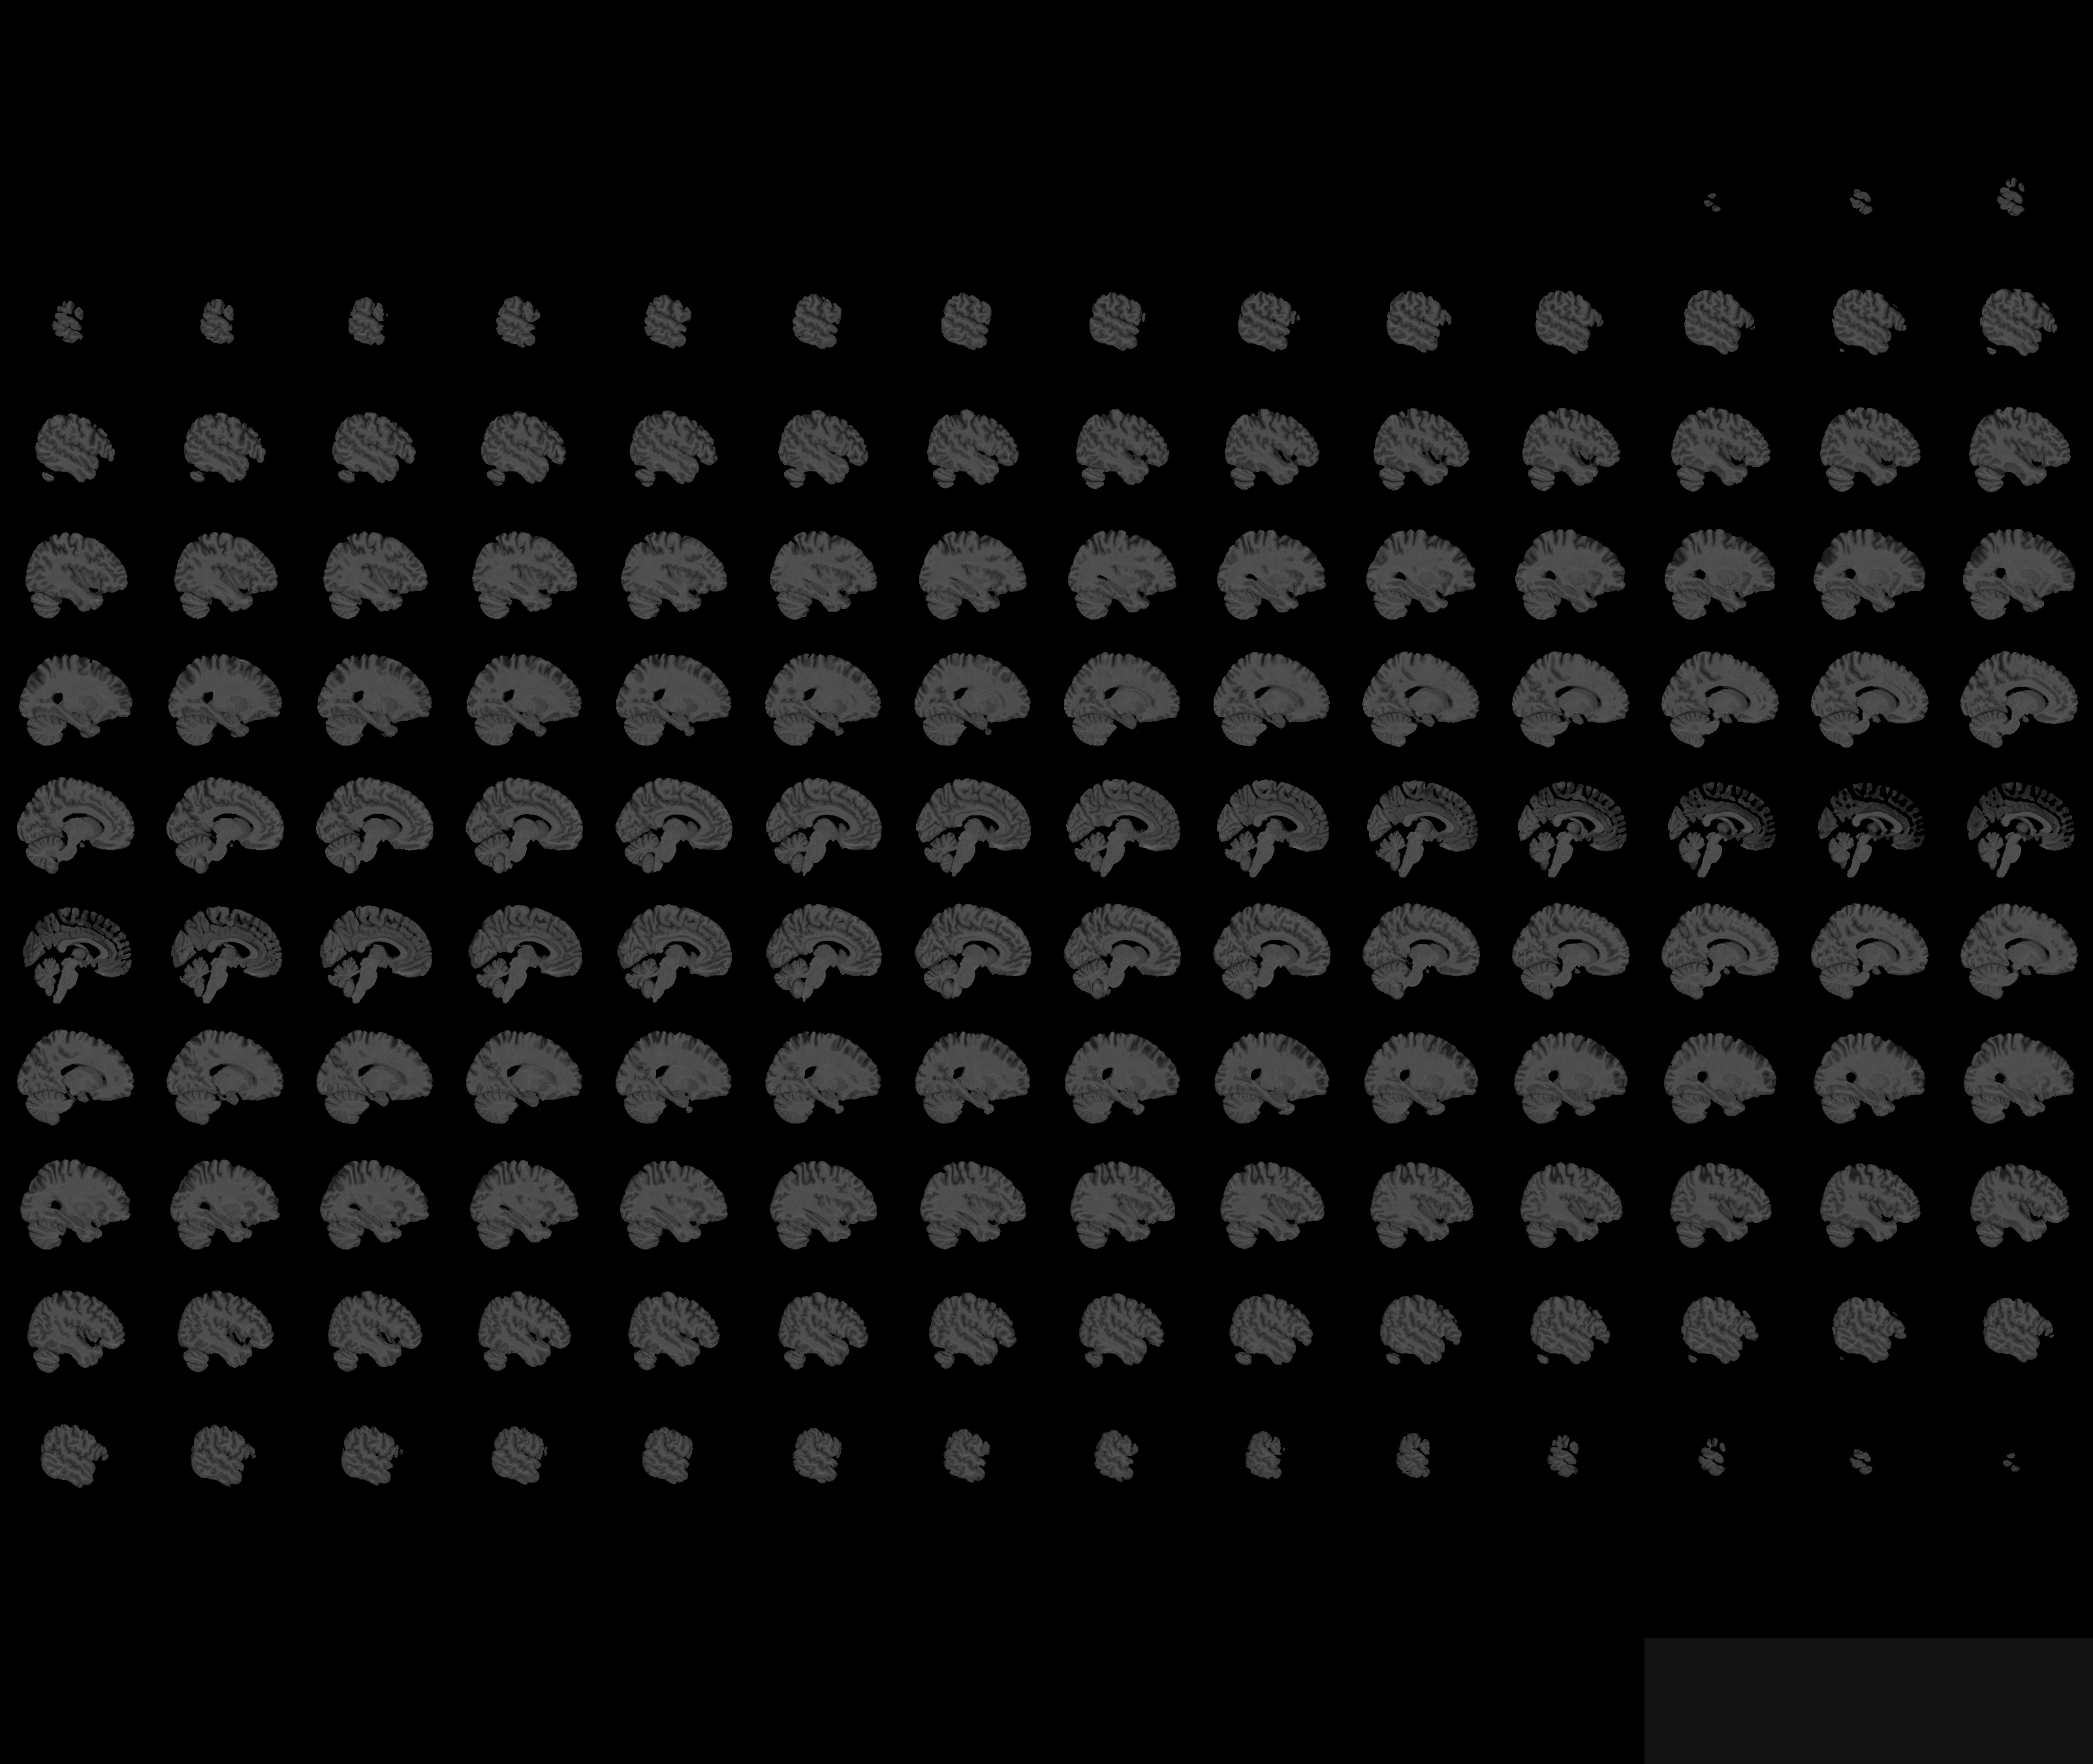
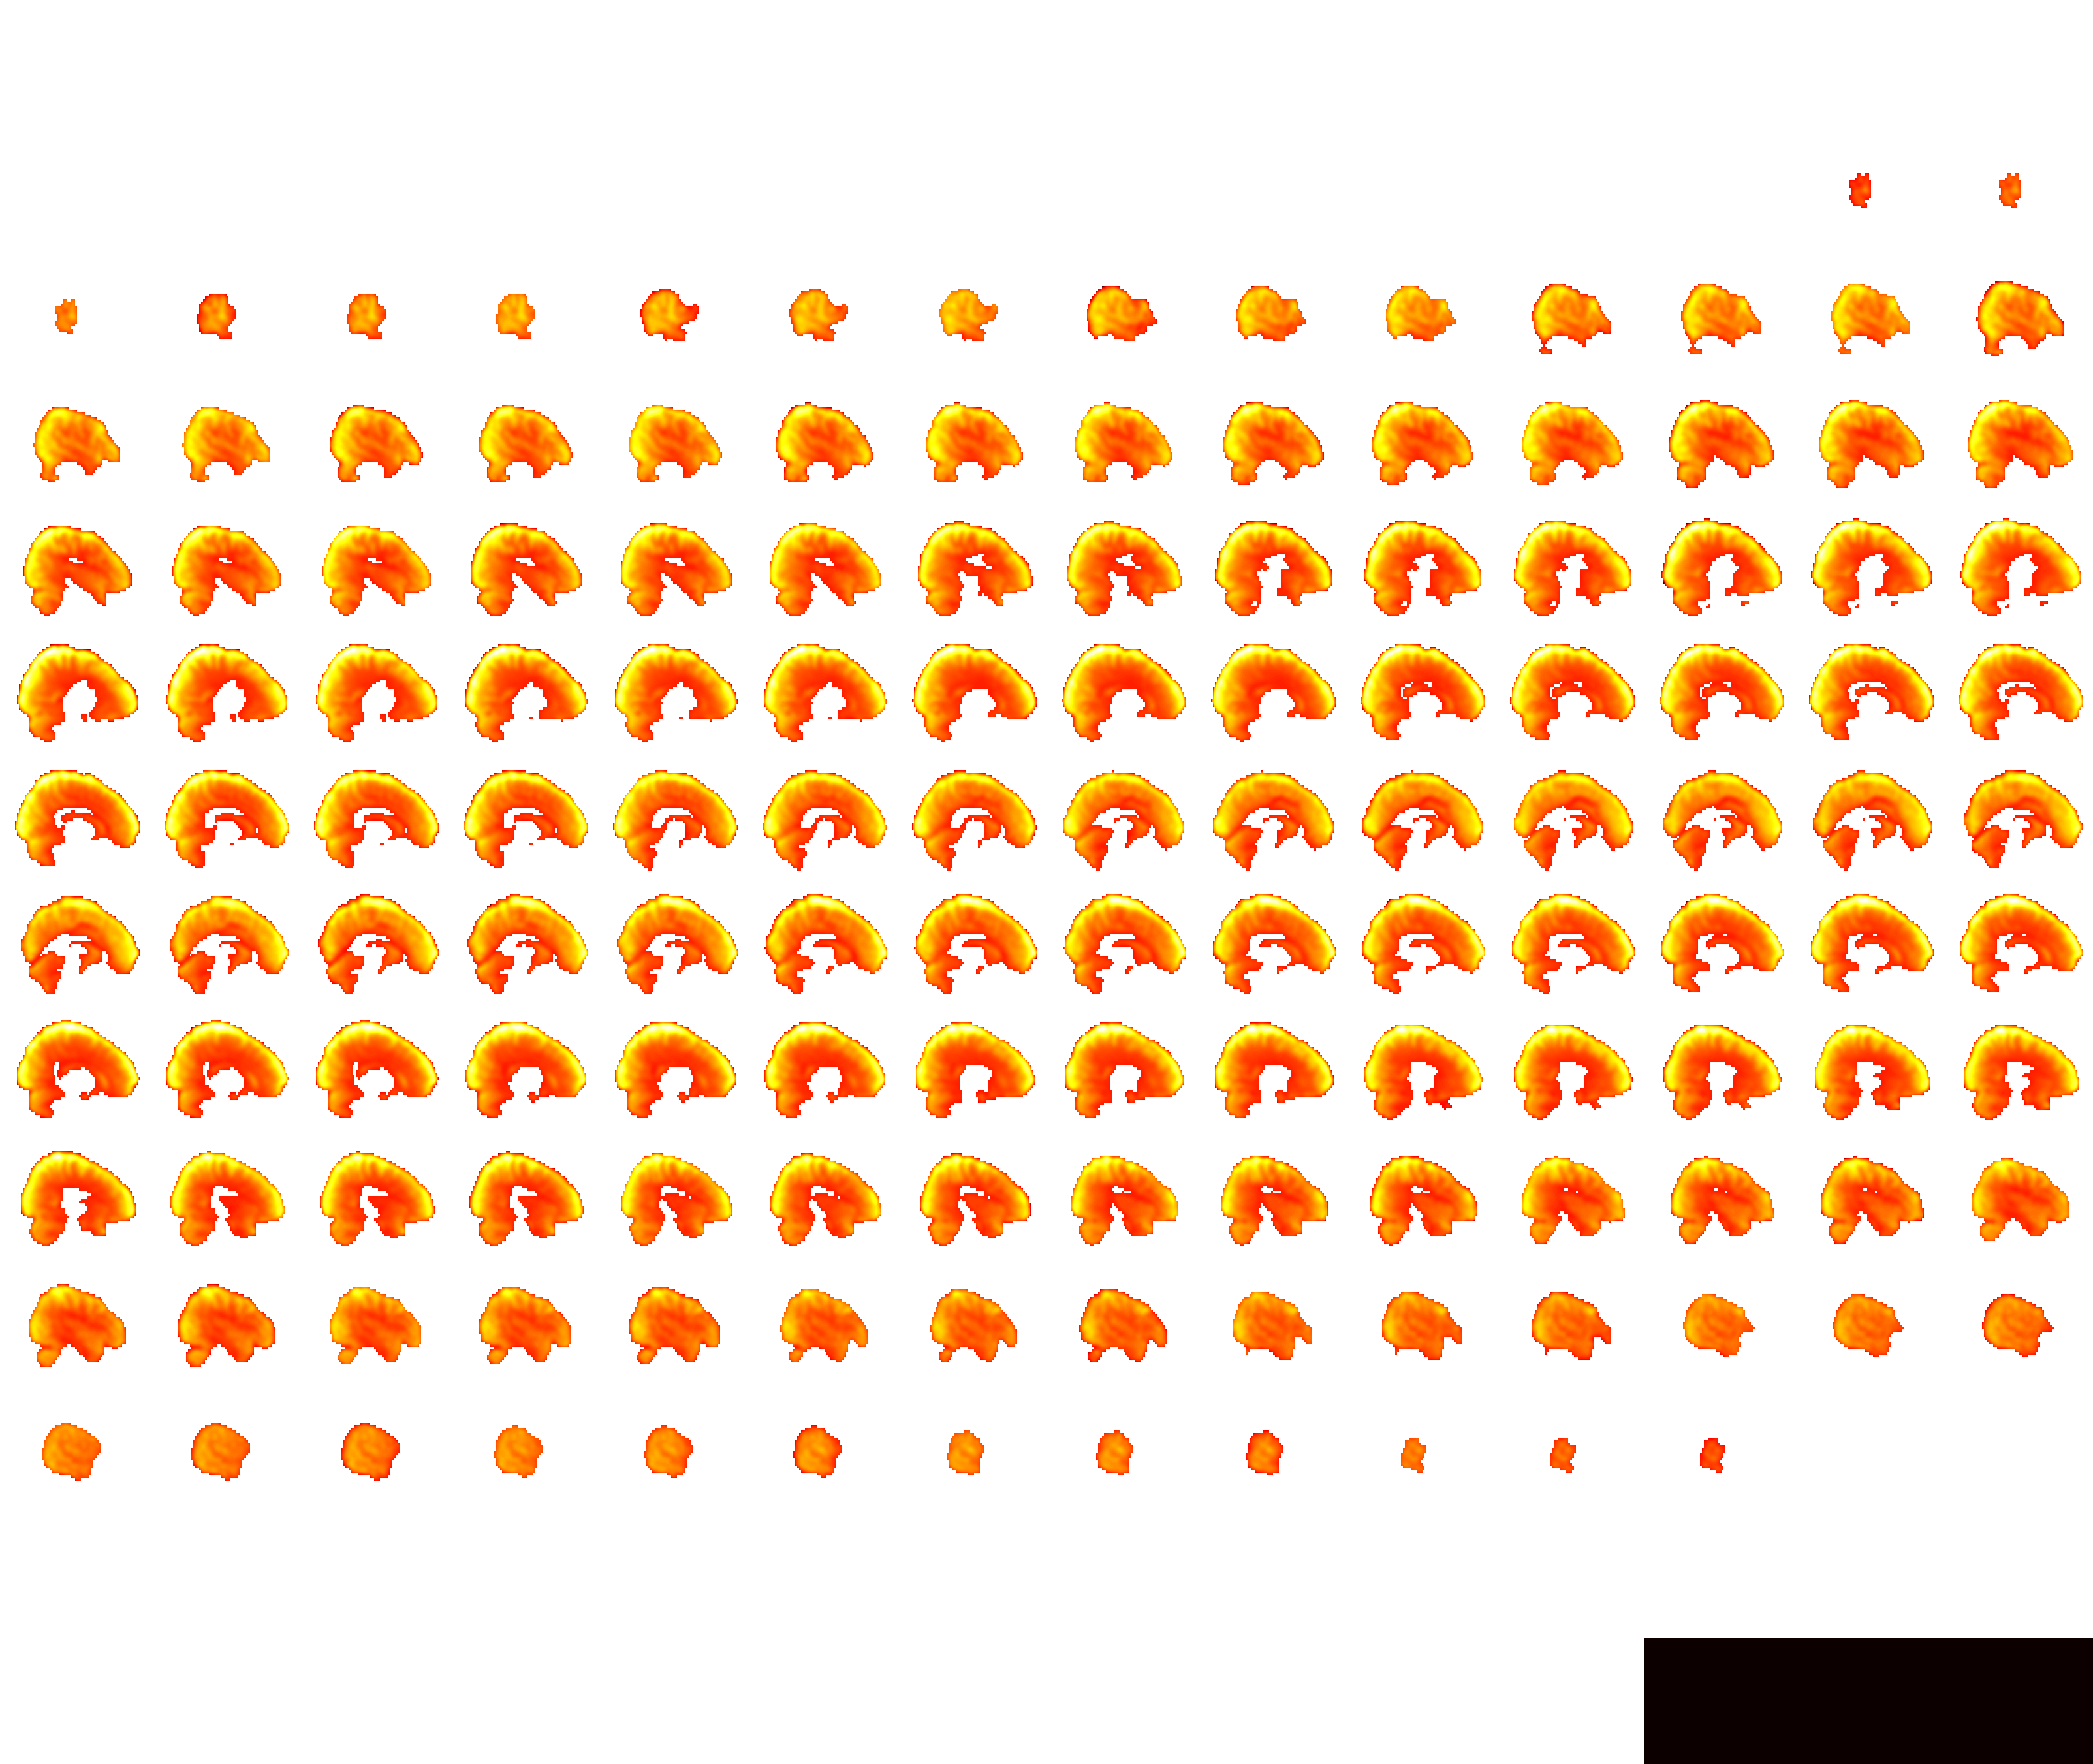

In [43]:
niplot.view_img(nimage.mean_img(cleaned_bold), threshold='auto', bg_img=anat00)

<AxesSubplot:label='conditions', ylabel='scan number'>

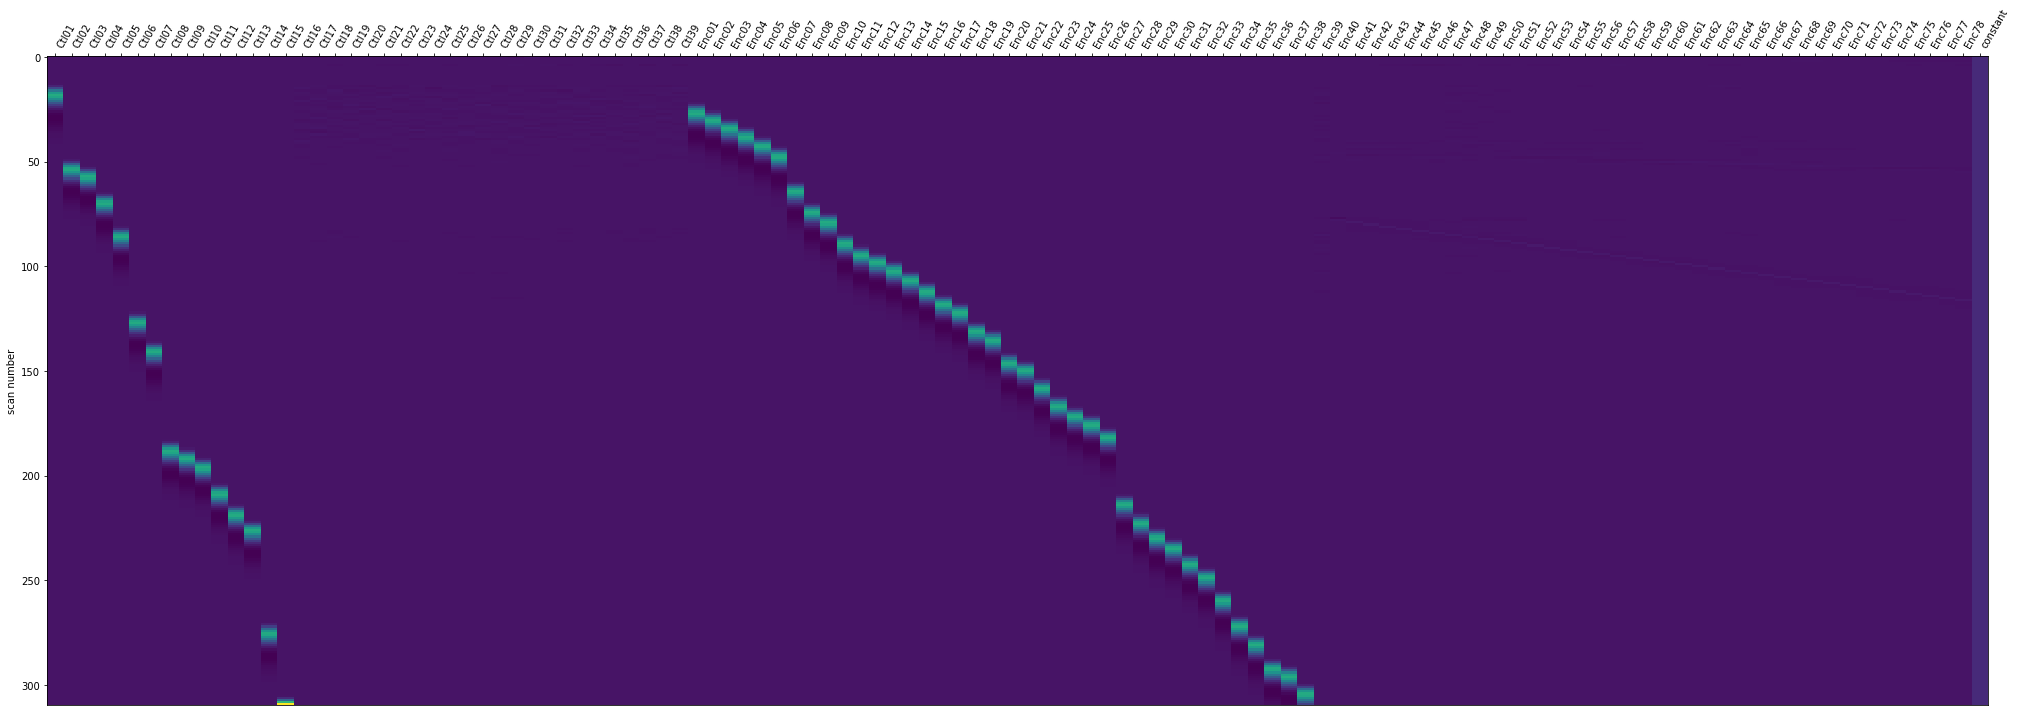

In [47]:
niplot.plot_design_matrix(design00)

In [48]:
help(make_first_level_design_matrix)

Help on function make_first_level_design_matrix in module nilearn.glm.first_level.design_matrix:

make_first_level_design_matrix(frame_times, events=None, hrf_model='glover', drift_model='cosine', high_pass=0.01, drift_order=1, fir_delays=[0], add_regs=None, add_reg_names=None, min_onset=-24, oversampling=50)
    Generate a design matrix from the input parameters
    
    Parameters
    ----------
    frame_times : array of shape (n_frames,)
        The timing of acquisition of the scans in seconds.
    
    events : DataFrame instance, optional
        Events data that describes the experimental paradigm.
         The DataFrame instance might have these keys:
            'onset': column to specify the start time of each events in
                     seconds. An error is raised if this key is missing.
            'trial_type': column to specify per-event experimental conditions
                          identifier. If missing each event are labelled
                          'dummy' a

In [ ]:
difumo64 = nilearn.datasets.fetch_atlas_difumo(64, 3, data_dir=os.getcwd())
difumo_sorted = pd.DataFrame(difumo64.labels).iloc[:, 1:]

In [ ]:
pd.DataFrame(difumo64.labels)

In [ ]:
vizpatt = re.compile('\.*\.*occipital\.*|visual', re.I)
test_str = 'Parieto-occipital sulcus anterior RH'
bool(vizpatt.findall(test_str))

In [ ]:
visual_areas = difumo_sorted.difumo_names.str.contains(
    re.compile('\.*occipital\.*|\.*visual\.*|\.*temporal\.*', re.I)).replace(False, pd.NA).dropna(how='all').index

In [ ]:
difumo_sorted.yeo_networks17.unique()

In [ ]:
yeo7_vis=difumo_sorted.loc[difumo_sorted.yeo_networks7=='VisCent'].difumo_names.index.tolist()

In [ ]:
# msdl = nilearn.datasets.fetch_atlas_msdl(data_dir=os.getcwd())

In [ ]:
# len(msdl.labels), len(msdl.networks)
# pd.DataFrame(tuple(dict(msdl).items())[1:-1])

In [ ]:
nimage.load_img(smith.bm10).

In [ ]:
visual_rois = nimage.index_img(load_img(difumo64.maps),
                                      difumo_sorted.loc[yeo7_vis].index.tolist())

In [ ]:
visual_mask = nilearn.masking.intersect_masks(nilea)


In [ ]:
v_resampled = nimage.concat_imgs(list(nimage.resample_img(nimage.new_img_like(ref_niimg=mask00,
                                                                      data=np.where(roi.get_fdata() > 0, 1,
                                                                                    roi.get_fdata())),
                                         target_shape=anat00.shape, target_affine=anat00.affine,
                                         force_resample=True, interpolation='nearest')
                for roi in nimage.iter_img(visual_rois)))

In [ ]:
set(v_resampled.get_fdata().flatten())

In [ ]:
# help(nilearn.datasets.fetch_atlas_difumo)

In [ ]:
niplot.plot_prob_atlas(visual_rois, bg_img=anat00)

In [ ]:
# visual_rois_resampled = nimage.concat_imgs(list(np.reshape(np.where(data.get_fdata() > 0, 1,
#                                                                            data.get_fdata()), mask00.shape)
#                                                        for data in list(nimage.iter_img(visual_rois))))

In [ ]:
# help(nimage.resample_img)

In [ ]:
# v_roi_data = np.where(mean_img(visual_rois).get_fdata() > 0, 1, mean_img(visual_rois).get_fdata())
# vmask_img = nimage.resample_img(nimage.new_img_like(ref_niimg=mask00,data=v_roi_data),
#                               target_shape=mask00.shape, target_affine=mask00.affine,
#                                       force_resample=True, interpolation='nearest')

In [ ]:
# set(vmask_img.get_fdata().flatten())

In [ ]:
# boolmask=nimage.new_img_like(ref_niimg=mask00,
#                                     data=v_roi_data)
visual_masker = nilearn.input_data.NiftiMapsMasker(maps_img=visual_rois)

In [ ]:
model00 = FirstLevelModel(**glm_params).fit(cleaned_bold,design_matrices=design00)

In [ ]:
# model00 = FirstLevelModel(**glm_params).fit(cleaned_bold,design_matrices=design00.iloc[:,:-1])
# cdef = {'Enc':events00.condition.eq('Enc').astype(int).values,
#         'Ctl':events00.condition.eq('Ctl').astype(int).values}
# cdef['Enc-Ctl'] = cdef['Enc']-cdef['Ctl']

In [ ]:
# [:-1] to remove ``constant`` 
betamap = nimage.concat_imgs(tuple(model00.compute_contrast(cont, output_type='effect_size')
                                         for cont in
                                         np.diag(np.ones(model00.design_matrices_[0].shape[1])))[:-1])

In [ ]:
visual_masker.fit(betamap)

In [ ]:
sub_svc = sklearn.svm.LinearSVC(max_iter=300000, dual=True) # 0.66 avg acc up to now
n_tests = 15
scores, precision_df = [], []
for test in range(n_tests):
    X_enc_ctl = apply_mask(list(nimage.iter_img(betamap)), mask00)
#     X_enc_ctl = visual_masker.fit_transform(imgs=betamap)
#     X_enc_ctl = apply_mask(list(nimage.iter_img(betamap)),visual_roi_mask)
    X_enc_ctl = X_enc_ctl#np.round(X_enc_ctl, 4)
    y_enc_ctl = events00.condition.values
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC, LinearSVC
    from sklearn.metrics import accuracy_score, classification_report
    from sklearn.metrics import confusion_matrix, precision_score, f1_score
    from sklearn.model_selection import cross_val_predict, cross_val_score
    from sklearn.preprocessing import MinMaxScaler
    X_train, X_test, y_train, y_test = train_test_split(
        X_enc_ctl, # x
        y_enc_ctl, # y
        test_size = 0.4, # 60%/40% split
        shuffle = True, # shuffle dataset before splitting
        stratify = y_enc_ctl, # keep distribution of conditions consistent betw. train & test sets
        #random_state = 123  # if set number, same shuffle each time, otherwise randomization algo
        )
    # Test model on unseen data from the test set
    sub_svc.fit(X_train, y_train)
    y_pred = sub_svc.predict(X_test) # classify age class using testing data
    scores.append(sub_svc.score(X_test, y_test)) # get accuracy
    cr = classification_report(y_pred=y_pred, y_true=y_test) # get prec., recall & f1
    crdf = pd.DataFrame(tuple(filter(None,[line.split()[:-2]
                                           for line in cr.splitlines()]))).T.set_index(0).T
    precision_df.append(crdf)

print(np.mean(scores).round(2),
      pd.concat(precision_df))


In [ ]:
# Test model on unseen data from the test set
sub_svc.fit(X_train, y_train)
y_pred = sub_svc.predict(X_test) # classify age class using testing data
acc = sub_svc.score(X_test, y_test) # get accuracy

cr = classification_report(y_pred=y_pred, y_true=y_test) # get prec., recall & f1
# dir(cr)

# print results
# print(f'Accuracy\n{round(acc, 3)}\n{cr}')

In [ ]:
sub_svc = sklearn.svm.LinearSVC() # 0.68 avg acc up to now
# sub_svc = sklearn.linear_model.SGDClassifier()
# 
# Cross-validation within 10 folds of training set
# predict
# class_weight='balanced'
cv_y_pred = cross_val_predict(sub_svc, X_train, y_train,
                           groups=y_train, cv=10)
# scores
cv_acc = cross_val_score(sub_svc, X_train, y_train,
                     groups=y_train, cv=10)
print(f'Cross-validation accuracy: {cv_acc}')

# evaluate overall model performance on training data
overall_acc = accuracy_score(y_pred = cv_y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = cv_y_pred, y_true = y_train)
print(f'Accuracy\n{round(overall_acc, 3)}\n\nOverall Score\n{overall_cr}')

In [ ]:
# trial_betas = list(nimage.iter_img(betamap))[:-1]
# decoder = nilearn.decoding.FREMClassifier(standardize=False,
#                                           mask=mask00,
#                                           target_affine=cleaned_bold.affine,
#                                           target_shape=cleaned_bold.shape[:-1],
#                                           clustering_percentile = 20,
#                                           screening_percentile = 100,
#                                           mask_strategy='whole-brain-template')
# X_train, X_test, y_train, y_test = train_test_split(
#     trial_betas,
# #     apply_mask(trial_betas, mask00), # x
#     events00.condition, # y
#     test_size = 0.4, # 60%/40% split
#     shuffle = True, # shuffle dataset before splitting
#     stratify = events00.condition, # keep distribution of conditions consistent betw. train & test sets
#     #random_state = 123  # if set number, same shuffle each time, otherwise randomization algo
#     ) 
# decoder.fit(X_train, y_train)


In [ ]:
y_pred = decoder.predict(X_test)
# help(decoder.score)
# acc = decoder.score(X_test, y_test)
decoder_cr = classification_report(y_pred=y_pred, y_true=y_test) # get prec., recall & f1
# print results
print(decoder_cr)
# print(f'Accuracy\n{acc}\n{cr}')

In [ ]:
# model00.generate_report(contrasts=cdef,
#                         title=None, bg_img='MNI152TEMPLATE',
#                         threshold=3.09, alpha=0.001,
#                         cluster_threshold=0, height_control='fpr',
#                         min_distance=8.0, plot_type='slice', display_mode='ortho',
#                         report_dims=(1600, 800))

In [ ]:
# cont_def = dict(tuple((cond,events00.condition.str.contains(cond).astype(int).values)
#                       for cond in events00.condition.unique().tolist()))
# cont_def['Enc-Ctl'] = cont_def['Enc']-cont_def['Ctl']
# cont_def

In [ ]:
from nilearn.decoding import Decoder
# Here screening_percentile is set to 5 percent
# mask_img = haxby_dataset.mask
trial_betamap = nimage.concat_imgs(tuple(nimage.iter_img(betamap))[:-1])
decoder = Decoder(estimator='svc_l1', mask=mask00, smoothing_fwhm=None,
                  clustering_percentile = 20,
                  standardize=False, screening_percentile=5, scoring='accuracy')
decoder.fit(trial_betamap,
            events00.condition)
y_pred = decoder.predict(trial_betamap)

# Print the CV scores
print(decoder.cv_scores_['Enc'], decoder.cv_scores_['Ctl'])

In [ ]:
weight_img = decoder.coef_img_['Enc']
view_img(weight_img,
         title="SVM weights")
#          dim=-1)

In [ ]:

    


    # get map of coefficients    
    # coef_ = sub_svc.coef_
    # print(coef_.shape)
    #Return voxel weights into a nifti image using the NiftiMasker
    # coef_img = sub_masker.inverse_transform(coef_)
    #Save .nii to file
    # coef_img.to_filename(os.path.join(output_dir, 'Coef_maps', 'SVC_coeff_enc_ctl_sub-'+str(sub)+'.nii'))

enc_ctl_data = enc_ctl_data.append(pd.Series(s_data, index=enc_ctl_data.columns), ignore_index=True)

demo_data = sub_data.copy()
demo_data.reset_index(level=None, drop=False, inplace=True)

enc_ctl_data.insert(loc = 1, column = 'cognitive_status', value = demo_data['cognitive_status'],
                    allow_duplicates=True)
enc_ctl_data.insert(loc = 2, column = 'total_scrubbed_frames', value = demo_data['total_scrubbed_frames'],
                    allow_duplicates=True)
enc_ctl_data.insert(loc = 3, column = 'mean_FD', value = demo_data['mean_FD'], allow_duplicates=True)
enc_ctl_data.insert(loc = 4, column = 'hits', value = demo_data['hits'], allow_duplicates=True)
enc_ctl_data.insert(loc = 5, column = 'miss', value = demo_data['miss'], allow_duplicates=True)
enc_ctl_data.insert(loc = 6, column = 'correct_source', value = demo_data['correct_source'],
                    allow_duplicates=True)
enc_ctl_data.insert(loc = 7, column = 'wrong_source', value = demo_data['wrong_source'],
                    allow_duplicates=True)
enc_ctl_data.insert(loc = 8, column = 'dprime', value = demo_data['dprime'], allow_duplicates=True)
enc_ctl_data.insert(loc = 9, column = 'associative_memScore', value = demo_data['associative_memScore'],
                    allow_duplicates=True)    
    
enc_ctl_data.to_csv(os.path.join(output_dir, 'SVC_withinSub_enc_ctl_wholeBrain.tsv'),
    sep='\t', header=True, index=False)


In [ ]:
s_task = pd.read_csv(subject_data.events, sep='\t')
#rename "trial_type" column as "condition"
s_task.rename(columns={'trial_type':'condition'}, inplace=True)
confounds = Minimal().load(subject_data.bolds)
scanDur = confounds.shape[0]*2.5
#add columns to DataFrame
numCol = s_task.shape[1] 
insertCol = [4, numCol+1, numCol+2, numCol+3]
colNames = ['trial_type', 'unscanned', 'ctl_miss_hit', 'ctl_miss_ws_cs']
colVals = ['TBD', 0, 'TBD', 'TBD']
for i in range(0, len(colNames)):
    s_task.insert(loc=insertCol[i], column=colNames[i], value=colVals[i], allow_duplicates=True)

#The 'unscanned' column flag trials for which no brain data was acquired.
#The scan's duration is shorter than the trial's offset time
#(0 = data, 1 = no data)
for j in s_task[s_task['offset']>scanDur].index:
    s_task.loc[j, 'unscanned']=1

#pas trial numbers with zeros (on the left) to preserve trial 
#temporal order when trials are alphabetized
s_task['trial_number'] = s_task['trial_number'].astype('object',
                                                       copy=False)
for k in s_task.index:
    s_task.loc[k, 'trial_number'] = str(s_task.loc[k, 'trial_number']).zfill(3)

#trial_type should have a unique entry per row so that each trial 
#can be modelled as a separate condition
countEnc = 0
countCTL = 0
for m in s_task[s_task['condition']=='Enc'].index:
    countEnc = countEnc + 1
    s_task.loc[m, 'trial_type'] = 'Enc'+str(countEnc)
    if s_task.loc[m, 'position_accuracy'] == 0:
        s_task.loc[m, 'ctl_miss_hit']='missed'
        s_task.loc[m, 'ctl_miss_ws_cs']='missed'
    elif s_task.loc[m, 'position_accuracy'] == 1:
        s_task.loc[m, 'ctl_miss_hit']='hit'
        s_task.loc[m, 'ctl_miss_ws_cs']='wrongsource'
    elif s_task.loc[m, 'position_accuracy'] == 2:
        s_task.loc[m, 'ctl_miss_hit']='hit'
        s_task.loc[m, 'ctl_miss_ws_cs']='correctsource' 
for n in s_task[s_task['condition']=='CTL'].index:
    countCTL = countCTL + 1
    s_task.loc[n, 'trial_type'] = 'CTL'+str(countCTL)
    s_task.loc[n, 'ctl_miss_hit']='control'
    s_task.loc[n, 'ctl_miss_ws_cs']='control'

#78 encoding and 39 control trials if full scan
print('Number of encoding trials:  ', countEnc)
print('Number of control trials:  ', countCTL)
    
#keep only trials for which fMRI data was collected
s_task = s_task[s_task['unscanned']==0]

#Save vectors of trial labels (e.g., encoding vs control)
#to label trials for classification analyses
ttypes1 = s_task['condition']
# ttypes1.to_csv(outTask_dir+'/sub-'+id+'_enco_ctl.tsv',
#               sep='\t', header=True, index=False)

ttypes2 = s_task['ctl_miss_hit']
# ttypes2.to_csv(outTask_dir+'/sub-'+id+'_ctl_miss_hit.tsv',
#               sep='\t', header=True, index=False)

ttypes3 = s_task['ctl_miss_ws_cs']
# ttypes3.to_csv(outTask_dir+'/sub-'+id+'_ctl_miss_ws_cs.tsv',
#               sep='\t', header=True, index=False)


#from s_task dataframe, create an events dataframe to create a design matrix 
#that will be inputed into a first-level model in nistats
ev_cols = ['onset', 'duration', 'trial_type', 'condition', 'ctl_miss_hit', 
           'ctl_miss_ws_cs', 'trial_number']
all_events = s_task[ev_cols]  

print(all_events.shape)
print(all_events.iloc[0:30, :])


In [ ]:
conditions = dict(tuple((col, np.array(list(map(int,col==design_matrix0.columns))))
   for col in ['Enc','Ctl', 'constant']))
enc_minus_ctl = conditions['Enc'] - conditions['Ctl']
enc_minus_const = conditions['Enc'] - conditions['constant']
ctl_minus_const =  conditions['Ctl'] - conditions['constant']

**Step3 : Implement first-level model (implements regression in nistats), generate contrasts and output maps of beta values (parameter estimators; one map of betas per trial).

**About first-level model:

Note 1: nistats.first_level_model provides an interface to use the glm implemented in nistats.regression

Note 2: each encoding trial is modelled as a separate condition to obtain separate maps of beta values (model's output type to get betas = **effect sizes** (Nistats name), aka parameter estimates)

**UPDATE: a separate model is created to obtain a beta map for each trial. 
The trial of interest is modelled as a unique condition (it has its own column in the design matrix), and the other trials are modelled together.
Version A: beside the trial of interest (1 regressor), the control trials and encoding trials are modelled separately (2 regressors)
Version B: beside the trial of interest (1 regressor), the control trials and encoding trials are modelled together as a single "other_trials" condition (1 regressor)

Note 3: the first_level_model can either be given a pre-constructed **design matrix** (built from the events and confounds files in a separate preparatory step) as a parameter, or be given the **events and confounds** files directly as parameters (skipping the need to create a design matrix in a separate step). In the second situation, the model will generate and output the design matrix.  

As a parameter to the first-level-model, the design matrix takes precedence over the events and confounds parameters.

Nistats link on design matrices:
https://nistats.github.io/auto_examples/04_low_level_functions/plot_design_matrix.html

https://nistats.github.io/modules/generated/nistats.design_matrix.make_first_level_design_matrix.html

Example where the design matrix is created directly within the first level model interface by inputing events and confounds files directly as parameters (I'm not doing that here): https://nistats.github.io/auto_examples/01_tutorials/plot_first_level_model_details.html#running-a-basic-model

CHOSEN: 2-step method. Create design matrix directly from events file and confounds outputed from NIAK (resample directory), then generate and fit first-level-model

**About contrasts and maps of beta values (parameter estimators):

When each trial is modeled as a separate condition, it is represented as its own column in the design matrix. 

To access the estimated coefficients (betas of the GLM model), we need to specify "canonical contrasts" (one per trial) that isolate design matrix columns (each contrast has a single 1 in its corresponding colum, and 0s for all the other columns).

Sources of info: how to extract beta maps in nistats (instructions are a bit obscure)
https://15-35545854-gh.circle-artifacts.com/0/home/ubuntu/nistats/doc/_build/html/auto_examples/plot_spm_auditory.html
https://github.com/poldracklab/fitlins/pull/48
https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html#nistats.first_level_model.FirstLevelModel


**Version A: A separate model created for each trial.
Trial of interest modelled as its own condition, and other trials are modelled as two conditions: control, and encoding (excluding trial of interest)


In [ ]:
#Apply 8mm smoothing since using unsmoothed preprocessed data 
#taken from NIAK's "resample" output directory
fmri_imgNS = load_img(subject_data.bolds)
fmri_img = image.smooth_img(fmri_imgNS, 8)

#Define parameters related to image acquisition
# time in seconds & number of frames
# Frame times for each epi scan
# alternatives to 'spm': 'glover', or 'spm + derivative'

# hrf_model, numTrials = 'spm', 

# This concatenation step might become obsolete, test Nilearn concatenation based on padded numbers!!
# Compile list of beta maps and their trial number, to be sorted by order of trial
all_betas_filelist_A = []

#Create a design matrix, first level model and beta map for each encoding and control trial 
# 117 trials if full scan (no missing frames)
for i in tqdm(list(range(all_events.shape[0]))):

    #copy all_events dataframe to keep the original intact
    events = all_events.copy(deep = True)
    #Determine trial number and condition (encoding or control)
    tnum, tname = events.iloc[i, 6], events.iloc[i, 2]
    #Version A: (2 conditions modelled separately)
    #modify trial_type column to model only the trial of interest
    events['trial_type'] = ['X_'+row[1].condition if row[1].trial_number == tnum
                            else row[1].condition for row in events.iterrows()]
    #verify: what determines the order of columns in design matrix?    
    #remove unecessary columns
    events = events[['onset', 'duration', 'trial_type']]
    #create design matrix
    design = make_first_level_design_matrix(**design_params)    
    #create & fit model - Should data be standardized?
    trial_model = FirstLevelModel(**glm_params).fit(fmri_img,
                                                    design_matrices=design)
    design_matrix = trial_model.design_matrices_[0]

    #sanity check: print design matrices and corresponding parameter labels
    #Contrast vector: 1 in design matrix column that corresponds to trial of interest, 0s elsewhere
    contrast_vec = np.repeat(0, design_matrix.shape[1])
    contrast_vec[0] = 1
    print(contrast_vec)
#     break
    #compute contrast's beta maps with ``model.compute_contrast``
    #https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html
    b_map = trial_model.compute_contrast(contrast_vec,
                                         output_type='effect_size') #"effect_size" for betas
    all_betas_filelist_A.append(b_map)
#     b_name = os.path.join(outBeta_dir_A, 'betas_sub'+str(id)+'_Trial'+str(tnum)+'_'+tname+'.nii')
#     #export b_map .nii image in output directory
#     nibabel.save(b_map, b_name)
#     print(os.path.basename(b_name))
#     all_betas_filelist_A.append(b_name)

    
alltrials_betas_A = nibabel.funcs.concat_images(images=all_betas_filelist_A, check_affines=True, axis=None)
# print(alltrials_betas_A.shape)
# nibabel.save(alltrials_betas_A, os.path.join(outBeta_dir_A, 'concat_all_betas_sub'+str(id)+'.nii'))
    

In [ ]:
view_img(mean_img(alltrials_betas_A),bg_img=anat0, threshold='auto')

**Version B: A separate model created for each trial.
Trial of interest modelled as its own condition, and other trials (encoding and control, excluding trial of interest) are modelled as a single condition

In [ ]:
outBeta_dir_B = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/OneModelPerTrial_B'
all_betas_filelist_B = []
####

#Create a design matrix, first level model and beta map for each encoding and control trial 
for i in range (0, numTrials):

    #copy all_events dataframe to keep the original intact
    events = all_events.copy(deep = True)

    #Determine trial number and condition (encoding or control)
    tnum = events.iloc[i, 6]
    currentCondi = events.iloc[i, 3]
    tname = events.iloc[i, 2]
        
    #Version A: (2 conditions modelled separately)
    #modify trial_type column to model only the trial of interest 
    for j in events.index:
        if events.loc[j, 'trial_number'] != tnum:
            events.loc[j, 'trial_type']= 'X_otherCondi'
            #X for condition to remain in alphabetical order: trial of interest, X_CTL, X_Enc
    #verify: what determines the order of columns in design matrix?    

    #remove unecessary columns    
    cols = ['onset', 'duration', 'trial_type']
    events = events[cols]
    
    #create the model
    s_model = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
                               hrf_model = hrf_model)    
    #Should data be standardized?

    #create the design matrices
    design = make_first_level_design_matrix(frame_times,
                                            events=events,
                                            drift_model=None,
#                                             add_regs=confounds, 
                                            hrf_model=hrf_model)
    
    #fit model with design matrix
    s_model = s_model.fit(fmri_img, design_matrices = design)
    
    design_matrix = s_model.design_matrices_[0]
    
    #sanity check: print design matrices and corresponding parameter labels
    #plot outputed design matrix for visualization
    print(str(tnum), ' ', tname, ' ', design_matrix.columns[0:3])
    plot_design_matrix(design_matrix)
    plt.show()

    #Contrast vector: 1 in design matrix column that corresponds to trial of interest, 0s elsewhere
    contrast_vec = np.repeat(0, design_matrix.shape[1])
    contrast_vec[0] = 1

    #compute the contrast's beta maps with the model.compute_contrast() method,
    #based on contrast provided. 
    #https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html
    b_map = s_model.compute_contrast(contrast_vec, output_type='effect_size') #"effect_size" for betas
    b_name = os.path.join(outBeta_dir_B, 'betas_sub'+str(id)+'_Trial'+str(tnum)+'_'+tname+'.nii')
    #export b_map .nii image in output directory
    nibabel.save(b_map, b_name)
    print(os.path.basename(b_name))
    all_betas_filelist_B.append(b_name)
    
alltrials_betas_B = nibabel.funcs.concat_images(images=all_betas_filelist_B, check_affines=True, axis=None)
print(alltrials_betas_B.shape)
nibabel.save(alltrials_betas_B, os.path.join(outBeta_dir_B, 'concat_all_betas_sub'+str(id)+'.nii'))



In [ ]:
outBeta_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/Conditions_Contrasts'

#Model 1: encoding vs control conditions
events1 = all_events.copy(deep = True)
cols = ['onset', 'duration', 'condition']
events1 = events1[cols]
events1.rename(columns={'condition':'trial_type'}, inplace=True)

print(events1.head())

#create the model
model1 = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
                         hrf_model = hrf_model)    
#Should data be standardized?

#create the design matrices
design1 = make_first_level_design_matrix(frame_times, events=events1,
                                        drift_model=None, add_regs=confounds, 
                                        hrf_model=hrf_model)

#fit model with design matrix
model1 = model1.fit(fmri_img, design_matrices = design1)    

design_matrix1 = model1.design_matrices_[0]    
plot_design_matrix(design_matrix1)
plt.show()
print(design_matrix1.columns[0:5])

#Condition order: control, encoding (alphabetical)

#contrast 1.1: control condition
ctl_vec = np.repeat(0, design_matrix1.shape[1])
ctl_vec[0] = 1
b11_map = model1.compute_contrast(ctl_vec, output_type='effect_size') #"effect_size" for betas
b11_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ctl.nii')
nibabel.save(b11_map, b11_name)
print(os.path.basename(b11_name))
print(ctl_vec)

#contrast 1.2: encoding condition
enc_vec = np.repeat(0, design_matrix1.shape[1])
enc_vec[1] = 1
b12_map = model1.compute_contrast(enc_vec, output_type='effect_size') #"effect_size" for betas
b12_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_enc.nii')
nibabel.save(b12_map, b12_name)
print(os.path.basename(b12_name))
print(enc_vec)

#contrast 1.3: encoding minus control 
encMinCtl_vec = np.repeat(0, design_matrix1.shape[1])
encMinCtl_vec[1] = 1
encMinCtl_vec[0] = -1
b13_map = model1.compute_contrast(encMinCtl_vec, output_type='effect_size') #"effect_size" for betas
b13_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_enc_minus_ctl.nii')
nibabel.save(b13_map, b13_name)
print(os.path.basename(b13_name))
print(encMinCtl_vec)


In [ ]:
#Model 2: missed vs hit encoding trials
events2 = all_events.copy(deep = True)
cols2 = ['onset', 'duration', 'ctl_miss_hit']
events2 = events2[cols2]
events2.rename(columns={'ctl_miss_hit':'trial_type'}, inplace=True)

print(events2.iloc[0:15, :])

#create the model
model2 = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
                         hrf_model = hrf_model)    
#Should data be standardized?

#create the design matrices
design2 = make_first_level_design_matrix(frame_times, events=events2,
                                        drift_model=None, add_regs=confounds, 
                                        hrf_model=hrf_model)

#fit model with design matrix
model2 = model2.fit(fmri_img, design_matrices = design2)    

design_matrix2 = model2.design_matrices_[0]    
plot_design_matrix(design_matrix2)
plt.show()
print(design_matrix2.columns[0:5])

##Condition order: control, hit, missed (alphabetical)

#contrast 2.1: miss 
miss_vec = np.repeat(0, design_matrix2.shape[1])
miss_vec[2] = 1
b21_map = model2.compute_contrast(miss_vec, output_type='effect_size') #"effect_size" for betas
b21_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_miss.nii')
nibabel.save(b21_map, b21_name)
print(os.path.basename(b21_name))
print(miss_vec)

#contrast 2.2: hit 
hit_vec = np.repeat(0, design_matrix2.shape[1])
hit_vec[1] = 1
b22_map = model2.compute_contrast(hit_vec, output_type='effect_size') #"effect_size" for betas
b22_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_hit.nii')
nibabel.save(b22_map, b22_name)
print(os.path.basename(b22_name))
print(hit_vec)

#contrast 2.3: hit minus miss
hit_min_miss_vec = np.repeat(0, design_matrix2.shape[1])
hit_min_miss_vec[1] = 1
hit_min_miss_vec[2] = -1
b23_map = model2.compute_contrast(hit_min_miss_vec, output_type='effect_size') #"effect_size" for betas
b23_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_hit_minus_miss.nii')
nibabel.save(b23_map, b23_name)
print(os.path.basename(b23_name))
print(hit_min_miss_vec)

#contrast 2.4: hit minus control
hit_min_ctl_vec = np.repeat(0, design_matrix2.shape[1])
hit_min_ctl_vec[1] = 1
hit_min_ctl_vec[0] = -1
b24_map = model2.compute_contrast(hit_min_ctl_vec, output_type='effect_size') #"effect_size" for betas
b24_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_hit_minus_ctl.nii')
nibabel.save(b24_map, b24_name)
print(os.path.basename(b24_name))
print(hit_min_ctl_vec)

#contrast 2.5: miss minus control 
miss_min_ctl_vec = np.repeat(0, design_matrix2.shape[1])
miss_min_ctl_vec[2] = 1
miss_min_ctl_vec[0] = -1
b25_map = model2.compute_contrast(miss_min_ctl_vec, output_type='effect_size') #"effect_size" for betas
b25_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_miss_minus_ctl.nii')
nibabel.save(b25_map, b25_name)
print(os.path.basename(b25_name))
print(miss_min_ctl_vec)


In [ ]:
#Model 3: correct source vs wrong source encoding trials
events3 = all_events.copy(deep = True)
cols3 = ['onset', 'duration', 'ctl_miss_ws_cs']
events3 = events3[cols3]
events3.rename(columns={'ctl_miss_ws_cs':'trial_type'}, inplace=True)

print(events3.iloc[0:15, :])

#create the model
model3 = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
                         hrf_model = hrf_model)    
#Should data be standardized?

#create the design matrices
design3 = make_first_level_design_matrix(frame_times, events=events3,
                                        drift_model=None, add_regs=confounds, 
                                        hrf_model=hrf_model)

#fit model with design matrix
model3 = model3.fit(fmri_img, design_matrices = design3)    

design_matrix3 = model3.design_matrices_[0]    
plot_design_matrix(design_matrix3)
plt.show()
print(design_matrix3.columns[0:5])

##Condition order: control, correct source, missed, wrong source (alphabetical)

#contrast 3.1: wrong source 
ws_vec = np.repeat(0, design_matrix3.shape[1])
ws_vec[3] = 1
b31_map = model3.compute_contrast(ws_vec, output_type='effect_size') #"effect_size" for betas
b31_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ws.nii')
nibabel.save(b31_map, b31_name)
print(os.path.basename(b31_name))
print(ws_vec)

#contrast 3.2: correct source
cs_vec = np.repeat(0, design_matrix3.shape[1])
cs_vec[1] = 1
b32_map = model3.compute_contrast(cs_vec, output_type='effect_size') #"effect_size" for betas
b32_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs.nii')
nibabel.save(b32_map, b32_name)
print(os.path.basename(b32_name))
print(cs_vec)

#contrast 3.3: correct source minus wrong source
cs_minus_ws_vec = np.repeat(0, design_matrix3.shape[1])
cs_minus_ws_vec[1] = 1
cs_minus_ws_vec[3] = -1
b33_map = model3.compute_contrast(cs_minus_ws_vec, output_type='effect_size') #"effect_size" for betas
b33_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs_minus_ws.nii')
nibabel.save(b33_map, b33_name)
print(os.path.basename(b33_name))
print(cs_minus_ws_vec)

#contrast 3.4: correct source minus miss
cs_minus_miss_vec = np.repeat(0, design_matrix3.shape[1])
cs_minus_miss_vec[1] = 1
cs_minus_miss_vec[2] = -1
b34_map = model3.compute_contrast(cs_minus_miss_vec, output_type='effect_size') #"effect_size" for betas
b34_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs_minus_miss.nii')
nibabel.save(b34_map, b34_name)
print(os.path.basename(b34_name))
print(cs_minus_miss_vec)

#contrast 3.5: wrong source minus miss
ws_minus_miss_vec = np.repeat(0, design_matrix3.shape[1])
ws_minus_miss_vec[3] = 1
ws_minus_miss_vec[2] = -1
b35_map = model3.compute_contrast(ws_minus_miss_vec, output_type='effect_size') #"effect_size" for betas
b35_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ws_minus_miss.nii')
nibabel.save(b35_map, b35_name)
print(os.path.basename(b35_name))
print(ws_minus_miss_vec)

#contrast 3.6: correct source minus control
cs_minus_ctl_vec = np.repeat(0, design_matrix3.shape[1])
cs_minus_ctl_vec[1] = 1
cs_minus_ctl_vec[0] = -1
b36_map = model3.compute_contrast(cs_minus_ctl_vec, output_type='effect_size') #"effect_size" for betas
b36_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_cs_minus_ctl.nii')
nibabel.save(b36_map, b36_name)
print(os.path.basename(b36_name))
print(cs_minus_ctl_vec)

#contrast 3.7: wrong source minus control
ws_minus_ctl_vec = np.repeat(0, design_matrix3.shape[1])
ws_minus_ctl_vec[3] = 1
ws_minus_ctl_vec[0] = -1
b37_map = model3.compute_contrast(ws_minus_ctl_vec, output_type='effect_size') #"effect_size" for betas
b37_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_ws_minus_ctl.nii')
nibabel.save(b37_map, b37_name)
print(os.path.basename(b37_name))
print(ws_minus_ctl_vec)


In [ ]:
#Visualize beta maps

#plotting brain images in nilearn:
#http://nilearn.github.io/plotting/index.html

#define directory where subject's functional mask and anatomical scan reside
anat_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/anat/122922'
#subject's anatomical scan
anat = nibabel.load(os.path.join(anat_dir, 'anat_sub122922_nuc_stereonl.nii'))
plot_anat(anat)

beta_list = glob.glob(os.path.join(outBeta_dir, '*.nii'))

for beta in beta_list:
    print(beta)
    plot_img(beta)
    plot_stat_map(stat_map_img=beta, bg_img=anat, cut_coords=(0, 0, 0), threshold=0.001, colorbar=True)
    show()
